## SetUp

In [1]:
# install required dependencies
!pip install -qq transformers
!pip install -qq datasets
!pip install -qq umap-learn

     |████████████████████████████████| 4.7 MB 32.7 MB/s 
     |████████████████████████████████| 6.6 MB 59.9 MB/s 
     |████████████████████████████████| 120 kB 57.7 MB/s 
     |████████████████████████████████| 365 kB 10.0 MB/s 
     |████████████████████████████████| 212 kB 43.6 MB/s 
     |████████████████████████████████| 115 kB 45.2 MB/s 
     |████████████████████████████████| 127 kB 12.6 MB/s 
     |████████████████████████████████| 88 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 16.5 MB/s 


In [2]:
# import the necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

### Loading Data

* the data is scrapped and stored in [github](https://raw.githubusercontent.com/chimaobi-okite/NLP-Projects-Competitions/main/NewsCategorization/Data/), and also in [hugging-face](https://huggingface.co/datasets/okite97/news-data). It will be loaded as a hugging face dataset
* Load the data and generate validation split from the the train split

In [3]:
data_url = 'okite97/news-data'

In [4]:
dataset = load_dataset(data_url)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/okite97___csv/okite97--news-data-77215812580e30c7/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# split the train data to training and validation set
dataset_ = dataset["train"].train_test_split(train_size=0.85, seed=42) # initialize new dataset with train of old dataset
dataset['train'] = dataset_.pop('train') # override the train of datset with the new train
dataset['validation'] = dataset_.pop('test') # include a validation data to dataset
dataset  # view result

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 3983
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 828
    })
    validation: Dataset({
        features: ['Title', 'Excerpt', 'Category'],
        num_rows: 703
    })
})

## Expository Data Analysis

In [6]:

dataset.set_format(type='pandas')
df = dataset['train'][:]
df.head()

,Title,Excerpt,Category
0,Mali Beat Tunisia Amid Controversy as Referee...,Mali and Tunisia's Africa Cup of Nations game ...,sports
1,Commerzbank Posts $3.3 Billion Fourth-Quarter ...,Germany’s Commerzbank said on Thursday its net...,business
2,AI Emotion-detection Software Tested on Chines...,A camera system that uses AI and facial recogn...,tech
3,"Israel Must Be Taught a ‘Lesson’, Erdogan Tell...",Turkish President Recep Tayyip Erdogan has tol...,politics
4,Jeopardy! Gameshow Host Alex Trebek Dies Aged 80,Iconic TV show host Alex Trebek has died after...,entertainment


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


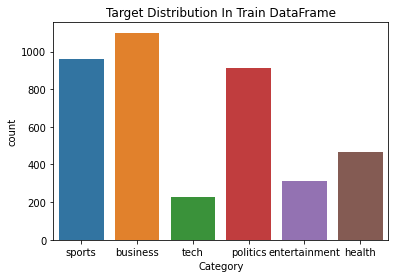

In [7]:
ax = sns.countplot('Category', data = df)
# for p in ax.patches:
#   size = df.shape[0]
#   x, y = p.get_x() , p.get_y()
#   height, width  = p.get_height(), p.get_width()
#   ax.annotate((x+width, height), '23')
plt.title('Target Distribution In Train DataFrame')
plt.show()

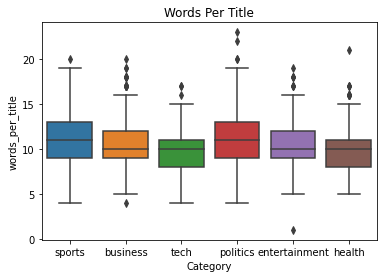

In [8]:
## see word cound distribution in title column
df['words_per_title'] = df['Title'].map(lambda x : len(str(x).split()))
sns.boxplot(y = 'words_per_title', x = 'Category', data = df)
plt.title('Words Per Title')
plt.show()

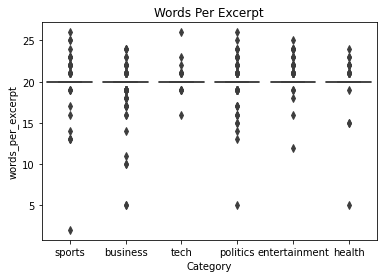

In [9]:
## see word cound distribution in Excerpt column
df['words_per_excerpt'] = df['Excerpt'].map(lambda x : len(str(x).split()))
sns.boxplot(y = 'words_per_excerpt', x = 'Category', data = df)
plt.title('Words Per Excerpt')
plt.show()

### Insights from EDA

* We can see that the dataset is Imbalanced with most news around business and politics and just few for tech and sports. This might be due to the fact that most Nigerians are more interested in politics, business and health.

* We can easily concatenate the title and excerpt column to a new column news without overshooting the number of words. So the models should be able to learn from this new column.

## Data Preparation For Modelling

* Reset data format
* Join the Title and Excerpt Columns
* Tokenize data
* Convert data to pytorch tensors

In [10]:
dataset.reset_format()

In [11]:
from transformers import AutoTokenizer

In [12]:
# define model checkpoint
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast = True)

In [13]:
sample_text = dataset['train']['Title'][0] + '.' + dataset['train']['Excerpt'][0]
sample_text

"Mali Beat Tunisia Amid Controversy  as Referee Blows for Full-Time Early.Mali and Tunisia's Africa Cup of Nations game finished in chaos after the referee first signalled for full-time on 85"

In [14]:
tokenizer(sample_text)

{'input_ids': [101, 16007, 3786, 13437, 13463, 6704, 2004, 5330, 13783, 2005, 2440, 1011, 2051, 2220, 1012, 16007, 1998, 13437, 1005, 1055, 3088, 2452, 1997, 3741, 2208, 2736, 1999, 8488, 2044, 1996, 5330, 2034, 4742, 3709, 2005, 2440, 1011, 2051, 2006, 5594, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
# define dictionary mappings that maps labels to catgories and vice-versa
labels =['health','business', 'politics', 'entertainment', 'sports', 'tech']
index2cat = {idx:cat for idx, cat in enumerate(labels)}
cat2index = {cat: idx for idx, cat in enumerate(labels)}
print(index2cat)

{0: 'health', 1: 'business', 2: 'politics', 3: 'entertainment', 4: 'sports', 5: 'tech'}


In [16]:
def process_news(batch):
  '''concat title and excerpt columns then create label column that maps 
  categories to index
  '''
  label = cat2index[batch['Category']]
  return {'News' :str(batch['Title']) + '.' + str(batch['Excerpt']),
          'label': label} 

def tokenize(batch):
  return tokenizer(batch['News'], padding=True, truncation=True)

In [17]:
data = dataset.map(process_news)
encoded_dataset =  data.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/3983 [00:00<?, ?ex/s]

  0%|          | 0/828 [00:00<?, ?ex/s]

  0%|          | 0/703 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [18]:
encoded_dataset.set_format('torch', columns = ['input_ids','attention_mask', 'label']) # convert lists of required columns to tensors

## Modelling 

### Evaluating model performance

Functions to plot a models confusion matrix and print classifcation reports

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [20]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized confusion matrix')
  plt.show()

In [21]:
def int2str(x):
  return index2cat.get(x)

def print_classification_report(y_true, y_pred):
  vfunc = np.vectorize(int2str) # function maps numpy array integers to string arrays
  y_true = vfunc(y_true) 
  y_pred = vfunc(y_pred)
  print(f1_score(y_true, y_pred, average='weighted'))
  print(classification_report(y_true,y_pred))

### Using Transformers As Feature Extractor

* Extract hidden state from a hugging face model checkpoint
* Reduce the feature size of the hidden state features, plot results and check usefulness of extracted features for modelling
* Build a logistics regression model using hidden states as features
* Check performance
* iterate with other model checkpoints

In [22]:
from transformers import AutoModel 
import torch
from sklearn.linear_model import LogisticRegression
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
def extract_hidden_state(batch):
  batch =  {k:v.to(device) for k,v in batch.items()} # save batch to device
  with torch.no_grad():
    outputs = model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])
  last_hidden_state = outputs.last_hidden_state[:, 0]
  return {'hidden_state' : last_hidden_state.cpu().numpy()}

In [25]:
dataset_hidden = encoded_dataset.map(extract_hidden_state, batched = True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
X_train = np.array(dataset_hidden['train']['hidden_state'])
X_valid = np.array(dataset_hidden['validation']['hidden_state'])
X_test = np.array(dataset_hidden['test']['hidden_state'])
y_train = np.array(encoded_dataset['train']['label'])
y_valid = np.array(encoded_dataset['validation']['label'])
y_test = np.array(encoded_dataset['test']['label'])
X_train.shape, X_valid.shape

((3983, 768), (703, 768))

In [27]:
X_scaled = MinMaxScaler().fit_transform(X_train)  # Scale features to [0,1] range
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled) # Initialize and fit UMAP
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y']) # Create a DataFrame of 2D embeddings
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,1.553160,9.253962,4
1,9.367008,10.594246,1
2,13.833177,10.711469,5
3,8.986342,7.676348,2
4,6.426192,7.163722,3


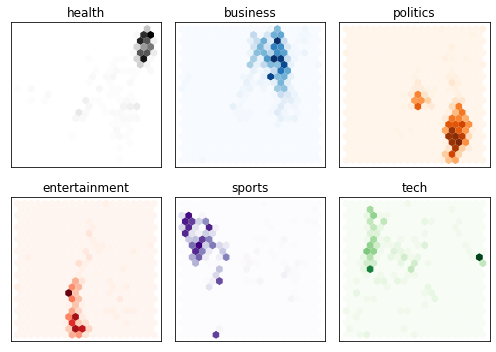

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap,
                 gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

We can see clear distinctions in the embeddings of the various classes. It shows that our distil-base model was able to extract useful features from the news dataset fed into it. We can also see a little overlap between the feature space of business and tech which might be difficult for a claasification model to distinguish. Let us now train a simple logistics regression model to learn from this features and evaluate it on the validation data.

In [29]:
lr_clf = LogisticRegression(max_iter=3000, random_state = 42) # We increase `max_iter` to guarantee convergence
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000, random_state=42)

In [30]:
# see performance of logistics regression model
print_classification_report(y_true = y_valid, y_pred = lr_clf.predict(X_valid))

0.882982617686808
               precision    recall  f1-score   support

     business       0.79      0.86      0.82       168
entertainment       0.91      0.87      0.89        69
       health       0.87      0.92      0.89        84
     politics       0.95      0.95      0.95       161
       sports       0.98      0.99      0.98       162
         tech       0.69      0.49      0.57        59

     accuracy                           0.89       703
    macro avg       0.86      0.85      0.85       703
 weighted avg       0.88      0.89      0.88       703



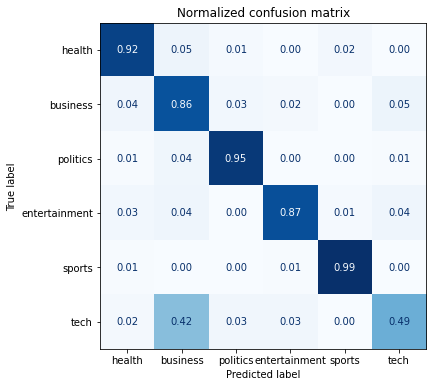

In [31]:
plot_confusion_matrix(lr_clf.predict(X_valid), y_valid, labels)

On iteration:
* with bert-base-uncased , f1_score = 86.67%
* with distilbert-uncased , f1_score = 88.30%
* with roberta-base-uncased , f1_score = 87.85%

Will use the distilbert going forward

In [32]:
# evaluate performance of logistics regression model on transformer-based feature extraction for test-set
print_classification_report(y_true = y_test, y_pred = lr_clf.predict(X_test))

0.8830944556627599
               precision    recall  f1-score   support

     business       0.82      0.89      0.85       224
entertainment       0.88      0.90      0.89        67
       health       0.92      0.86      0.89        97
     politics       0.92      0.92      0.92       190
       sports       0.98      0.95      0.97       199
         tech       0.58      0.49      0.53        51

     accuracy                           0.88       828
    macro avg       0.85      0.83      0.84       828
 weighted avg       0.88      0.88      0.88       828



### Build Transformer For Text Classification

* Build custom transformer head for text classification
* Define a configuration file
* Test model on a sample text to ensure expected results
* Define a compution metric
* Train model and push to hub

In [33]:
import torch.nn as nn
from transformers import DistilBertForSequenceClassification

from transformers import TrainingArguments
from transformers import AutoConfig
from transformers import Trainer
from huggingface_hub import notebook_login

In [34]:
num_labels = 6 
config = AutoConfig.from_pretrained(model_ckpt,num_labels = num_labels, id2label=index2cat, 
                                   label2id=cat2index) # initialize config file

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_model = DistilBertForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

In [36]:
# text model with sample news
inputs = torch.unsqueeze(torch.tensor(tokenizer(sample_text).input_ids),0).to(device)
attn_mask = torch.unsqueeze(torch.tensor(tokenizer(sample_text).attention_mask), 0).to(device)
label = torch.tensor([5]).to(device)

sequence_model(input_ids = inputs, attention_mask = attn_mask, labels = label)

SequenceClassifierOutput(loss=tensor(1.8310, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0016,  0.0052, -0.0215, -0.1284, -0.0123, -0.0768]],
       device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [37]:
# define a metric function
from sklearn.metrics import f1_score, accuracy_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [38]:
notebook_login() # login to hub

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [39]:
def model_init():
  return (DistilBertForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device))

In [40]:
# define training argument
batch_size = 16
num_epochs = 3
logging_steps = len(encoded_dataset['train'])// batch_size
output_dir = f'{model_ckpt}-najianews'
training_args = TrainingArguments(output_dir = output_dir,log_level = 'error',
                                  num_train_epochs= num_epochs,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  evaluation_strategy="epoch",
                                  save_steps=100, weight_decay=0.01, disable_tqdm=False,
                                  logging_steps=logging_steps, push_to_hub=True)

In [41]:
trainer = Trainer(model_init=model_init, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset= encoded_dataset['train'],
                  eval_dataset= encoded_dataset['validation'],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/okite97/distilbert-base-uncased-najianews into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.470900,0.324704,0.893314,0.889839
2,0.217400,0.384778,0.900427,0.895203
3,0.144400,0.378844,0.907539,0.907359


In [42]:
trainer.push_to_hub(commit_message='Training completed!')

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/255M [00:00<?, ?B/s]

Upload file runs/Aug25_11-50-57_42f398f6effe/events.out.tfevents.1661428280.42f398f6effe.74.0:  59%|#####8    …

To https://huggingface.co/okite97/distilbert-base-uncased-najianews
   2a05e0a..1d9ec11  main -> main

   2a05e0a..1d9ec11  main -> main

To https://huggingface.co/okite97/distilbert-base-uncased-najianews
   1d9ec11..d037349  main -> main

   1d9ec11..d037349  main -> main



'https://huggingface.co/okite97/distilbert-base-uncased-najianews/commit/1d9ec117a5c629692e05666ea8cf0e661f204f41'

#### Transformer Performance

In [43]:
## evaluate model on validation data
preds_output = trainer.predict(encoded_dataset['validation'])
y_preds = np.argmax(preds_output.predictions, axis = 1)
y_true = preds_output.label_ids

In [45]:
print_classification_report(y_true,y_preds)

0.9073589381747773
               precision    recall  f1-score   support

     business       0.86      0.87      0.86       168
entertainment       0.91      0.88      0.90        69
       health       0.92      0.90      0.91        84
     politics       0.95      0.96      0.96       161
       sports       0.99      0.99      0.99       162
         tech       0.69      0.68      0.68        59

     accuracy                           0.91       703
    macro avg       0.89      0.88      0.88       703
 weighted avg       0.91      0.91      0.91       703



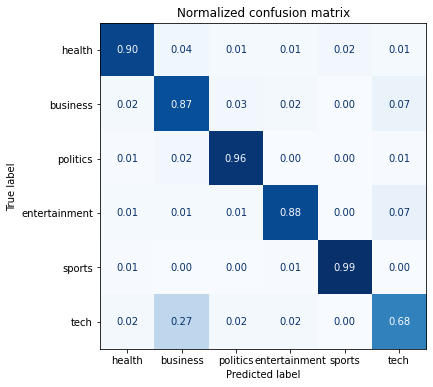

In [46]:
plot_confusion_matrix(y_preds, y_true, labels)

We can see a huge increase in performance from the previous model using transformer as feature extractor. The transformer model is able to now recognize 68% of all tech news unlike the logistics regression model that was able to recognize just 49%, also f1_score increased from 88% to 90%. To be sure the model works as expected, lets perform some error analysis

#### Error Analysis

In [56]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if
           k in tokenizer.model_input_names}  # save inputs to same device as model
  with torch.no_grad():
    outputs = sequence_model(**inputs)
  pred_labels = torch.argmax(outputs.logits, axis = -1)
  loss = cross_entropy(outputs.logits, batch['label'].to(device), reduction = 'none')
  return {'loss' : loss.cpu().numpy(),
          'predicted_label': pred_labels.cpu().numpy()}

In [57]:
news = encoded_dataset['train']['Title'][1] + encoded_dataset['train']['Excerpt'][1]
print(news)

Commerzbank Posts $3.3 Billion Fourth-Quarter Loss amid Major RestructuringGermany’s Commerzbank said on Thursday its net loss deepened to $3.3 billion in the fourth quarter, as the lender undergoes


In [58]:
encoded_dataset.set_format('torch', columns = ['input_ids', 'attention_mask', 'label'])

In [59]:
validation_dataset = encoded_dataset['validation'].map(forward_pass_with_label, batched = True, batch_size = 16)

  0%|          | 0/44 [00:00<?, ?ba/s]

In [60]:
validation_dataset.set_format('pandas')  # set format for validation data to pandas
columns = ['News', 'label', 'predicted_label','loss']
df_val = validation_dataset[:][columns] # use selected columns
df_val['label'] = df_val['label'].map(index2cat) # map labels index to category
df_val['predicted_label'] = df_val['predicted_label'].map(index2cat) # map predicted_labels to category

In [61]:
df_val.sort_values(by = 'loss', ascending = False).head(20)

,News,label,predicted_label,loss
197,UK Museum to Return Looted Benin Artefacts to ...,entertainment,sports,1.897539
554,Air Peace to Fly from Lagos and Port-Harcourt ...,business,health,1.894546
392,"After 10-Month Row, Emirates Now Keen on Fligh...",business,health,1.891281
662,Trey Songz Arrested After Fight with Police Of...,entertainment,sports,1.885579
569,Reggae Singer-songwriter Johnny Nash Dies Aged...,entertainment,sports,1.881635
584,Black Panther’s Letitia Wright Faces Backlash ...,entertainment,sports,1.880065
603,China Evergrande Sells Entire Stake in Streami...,business,tech,1.877933
115,"Deola Sagoe, Folake Coker Brighten Runway at T...",entertainment,sports,1.877022
361,"National Carrier, Nigeria Air, to Commence Ope...",business,health,1.876822
182,Legendary TV Host Larry King Dies at 87.Long-t...,entertainment,sports,1.874382


In [62]:
df_val.sort_values(by = 'loss', ascending = True).head(10)

,News,label,predicted_label,loss
667,Eight Covid-19 Cases Puts Raja Casablanca’s Ch...,sports,sports,1.686396
433,Anthony Joshua to Defend Heavyweight Titles ag...,sports,sports,1.686949
527,UK First Country to Approve Pfizer/BioNTech Co...,health,health,1.691039
468,Fury Says Joshua Handled Loss to RuIz ‘Like a ...,sports,health,1.694225
300,Prince William: Saving Earth Should Come Befor...,health,health,1.695719
207,"NDLEA Impounds Drugs from Nigeria to Brazil, U...",health,health,1.699661
699,"Fury-Wilder III: Promoter Looking outside US, ...",sports,health,1.700413
26,"Chelsea, Man City Fans Involved in Violent Cla...",sports,sports,1.702881
503,"Okagbare’s Doping Ban Extended, Keeping Nigeri...",sports,sports,1.703740
638,Newcastle Offer Season Ticket Refunds to Fans....,sports,sports,1.704896


##### Model Loss Interpretation

1. We can see the model's loss clearly defines how good a prediction is. Most wrong predictions has high losses showing the model isnt actually sure. 

2. Looking at other examples, we can see that this label misconception is the main reason behind most misclassifications. 

3. We can also see most of the misclassifications comes from the model classifying tech examples as business. The reason being that:
* In today's world,the top business leaders are tech companies so it is difficult to decouple one from the other. 
* There are just few tech examples in the dataset, with more, the model should be able to learn more useful features to correctly differentiate between the two classes.

### Evaluate model performance on test set

In [63]:
test_outputs = trainer.evaluate(encoded_dataset['test'])

In [64]:
test_outputs

{'eval_loss': 0.32805660367012024,
 'eval_accuracy': 0.9142512077294686,
 'eval_f1': 0.9152314557386296,
 'eval_runtime': 1.993,
 'eval_samples_per_second': 415.444,
 'eval_steps_per_second': 26.091,
 'epoch': 3.0}

Nice. Our performance on test set is very similar to that on validation set.

## Saving Model Using Pipeline


* import model as a pipeline 
* Use pipeline to make prediction on sample news from test set

In [65]:
from transformers import pipeline

In [66]:
model_id = 'okite97/distilbert-base-uncased-najianews'
classifier = pipeline('text-classification',model=model_id)

In [67]:
sample_news = encoded_dataset['test']['News'][6]
sample_news

"Lagos Suspends  NURTW From Parks, Takes Over Transport Union’s Operations.As the crisis rocking Nigeria's National Union of Road Transport Workers (NURTW) in the state continues to rage, the Lagos"

In [68]:
classifier(sample_news)

[{'label': 'business', 'score': 0.9778226017951965}]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


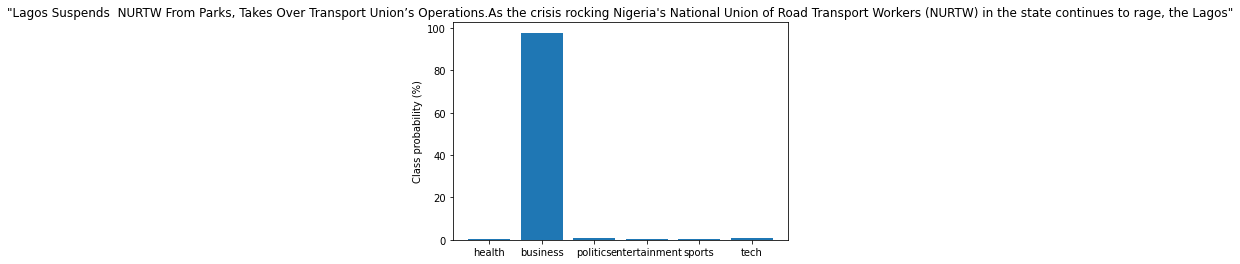

In [69]:
preds = classifier(sample_news, return_all_scores=True)
# visualize results
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{sample_news}"')
plt.ylabel("Class probability (%)")
plt.show()

## The End.